In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import itertools

plt.rcParams['svg.fonttype'] = 'none'


In [2]:
def load_results(run_idx, model_name, train_name, fix_unit = 'ID', train_seq_part = 'fix_and_choice', choice_only = False, choice_then_fix = False):
    
    to_save_folder = '/scratch/gpfs/erussek/RNN_project/Best_Param_Results'
    res_name_full = 'run_{}_model_name_{}_train_name_{}_fix_and_sim_bp'.format(run_idx, model_name, train_name)
    
    if train_seq_part == 'fix_only':
        res_name_full = 'run_{}_model_name_{}_train_name_{}_fix_and_sim_bp_fix_only'.format(run_idx, model_name, train_name)
        
    if choice_only:
        if train_name == 'train_sim_test_human':
            train_name = 'train_sim_test_sim'
                
        res_name_full = 'run_{}_train_name_{}_choice_only'.format(run_idx, train_name)
    
    if choice_then_fix:
        res_name_full = 'run_{}_train_name_{}_choice_then_fix'.format(run_idx, train_name)

    if fix_unit == 'all':
        
        if train_seq_part == 'fix_only':
            res_name_full = 'run_{}_model_name_{}_train_name_{}_fix_and_sim_bp_fu_all'.format(run_idx, model_name, train_name)
        else:
            res_name_full = 'run_{}_model_name_{}_train_name_{}_fix_and_sim_bp_fu_all_fix_and_choice'.format(run_idx, model_name, train_name)

        
    res_file_name = res_name_full + '.pickle'    
    res_full_file_name = os.path.join(to_save_folder, res_file_name)
    file = open(res_full_file_name, 'rb')
    res = pickle.load(file)
    
    return res

def load_results_all_runs(model_name,train_name, fix_unit = 'ID', train_seq_part = 'fix_and_choice', choice_only = False, choice_then_fix = False, n_runs = 20):
    
    results_list = []
    
    for run_idx in range(n_runs):
        res = load_results(run_idx, model_name, train_name, train_seq_part = train_seq_part, choice_only = choice_only, choice_then_fix = choice_then_fix, fix_unit = fix_unit)
        results_list.append(res)
        
    return results_list

def get_learning_curve_train_sim_or_human(model_name, train_name, fix_unit = 'ID', n_runs = 20, choice_only = False, choice_then_fix = False, train_seq_part = 'fix_and_choice', which_loss = 'simulation_loss_results'): 
    
    results_list = load_results_all_runs(model_name,train_name, train_seq_part = train_seq_part, fix_unit = fix_unit, n_runs = n_runs, choice_then_fix = choice_then_fix, choice_only = choice_only)
    
    loss_results_by_run = np.array([res[which_loss] for res in results_list])
        
    return np.mean(loss_results_by_run, axis=0), np.std(loss_results_by_run, axis=0)/np.sqrt(n_runs), results_list[0]['train_sequence_number'], results_list[0]['simulation_sequence_number'], results_list[0]['human_sequence_number']

def get_correlation_results(model_name, train_name, fix_unit = 'ID',train_seq_part = 'fix_and_choice', choice_only = False, choice_then_fix = False, which_r_sim = 'r_sim_by_n_back', n_runs = 20):
    
    results_list = load_results_all_runs(model_name,train_name, train_seq_part = train_seq_part, fix_unit = fix_unit, n_runs = n_runs, choice_then_fix = choice_then_fix, choice_only = choice_only)
    
    r_by_n_back = np.array([res[which_r_sim] for res in results_list])
    
    return np.mean(r_by_n_back, axis=0), np.std(r_by_n_back, axis=0)/np.sqrt(n_runs)


def load_results_control(run_idx, fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout):
    
    to_save_folder = '/scratch/gpfs/erussek/RNN_project/Control_Models1_HP'
    res_name_full = 'run_{}_fixunit_{}_d_model_{}_sim_lr_{}_human_lr_{}_nsim_{}_nhum_{}_do_{}'.format(run_idx, fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout)

    param_dict = {'fix_unit': fix_unit, 'd_model':d_model, 'sim_lr':sim_lr, 'human_lr':human_lr, 'n_simulation_sequences_train':n_simulation_sequences_train, 'n_human_sequences_train':n_human_sequences_train, 'dropout': dropout}                  
    res_file_name = res_name_full + '.pickle'
    res_full_file_name = os.path.join(to_save_folder, res_file_name)
    file = open(res_full_file_name, 'rb')
    res = pickle.load(file)
    return res, param_dict

def load_results_all_runs_control(fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 20, choice_only = False):
    
    results_list = []
    
    for run_idx in range(n_runs):
        res, param_dict = load_results_control(run_idx, fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout)
        results_list.append(res)
        
    return results_list, param_dict

def get_correlation_results_control(fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, which_r_sim = 'r_sim_by_n_back', n_runs = 20):
    
    results_list, param_dict = load_results_all_runs_control(fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = n_runs)
        
    r_by_n_back = np.array([res[which_r_sim] for res in results_list])
    
    return np.mean(r_by_n_back, axis=0), np.std(r_by_n_back, axis=0)/np.sqrt(n_runs)

#### params for control model

In [3]:
c_sim_lr = .001
c_human_lr = .001
n_sim_seq = 5e5
n_human_seq = 5e5
c_dropout=0
c_d_model = 16

In [4]:
# types of models...
model_names = ['LSTM', 'GRU', 'Transformer']
train_names = ['train_sim_test_sim', 'train_sim_test_human', 'train_human_test_human', 'train_sim_human_test_human']



## Train on simulated data, test on simulated / Human data

In [ ]:
colors = plt.cm.tab20(range(3))


train_name = train_names[0]

fig,ax = plt.subplots(1,3, figsize = (6,2.5), dpi = 300, sharex = True, sharey = True)

for model_idx, model_name in enumerate(model_names):
    
    ax[model_idx].set_title(model_name)
    
    these_tps = np.arange(-18,0,1)/10
    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, train_seq_part = 'fix_only', which_r_sim = 'r_sim_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr = np.flip(sem_r[:-1]), label = 'Fixation')#,  color = colors[1])

    # do the fix_only model...
    
    # get the choice only...
    mn_r_by_n_back, sem_r = get_correlation_results('MLP', train_name, which_r_sim = 'r_sim_by_n_back', n_runs = 20, choice_only = True)
    ax[model_idx].plot(0,mn_r_by_n_back,'o', label = 'Choice')
    
    # Fixation + Choice
    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, which_r_sim = 'r_sim_by_n_back', n_runs = 20)
    
    these_tps = np.arange(-18,1,1)/10
    # ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), 'r-', label='fixations + choice')
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = sem_r, label = 'Fixation and \nChoice'.format(model_name))#, color = colors[0])
    
    these_tps = np.arange(-18,0,1)/10
    for fu in ['all']:#['ID', 'sum', 'prop', 'all']:
        mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, c_sim_lr, 0, 5e5, 0, c_dropout, which_r_sim = 'r_sim_by_n_back', n_runs = 20)
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = 'Best Control',  color = 'gray', ls='-')
    
    
    
    ax[model_idx].set_xticks([-1.5, -1, -.5, 0])


    ax[model_idx].vlines(x=[0], ymin=.2, ymax=.6, color='k', ls = '--')




ax[2].legend(fontsize=8)

ax[0].set_ylabel('Simulated Test Data Accuracy \n (Pearson Correlation Coefficient)');
ax[1].set_xlabel('Time Point Relative to Choice (Seconds)')


#for label, ax in ax.items():
    # label physical distance to the left and up:
#trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].set_title(labels[i], loc = 'Left', fontsize = 'medium', weight = 'bold')

### Make the plot
plt.savefig("paper_figs/Train_Sim_Test_Sim_All_Models.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("paper_figs/Train_Sim_Test_Sim_All_Models.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)

### plot all the control models...


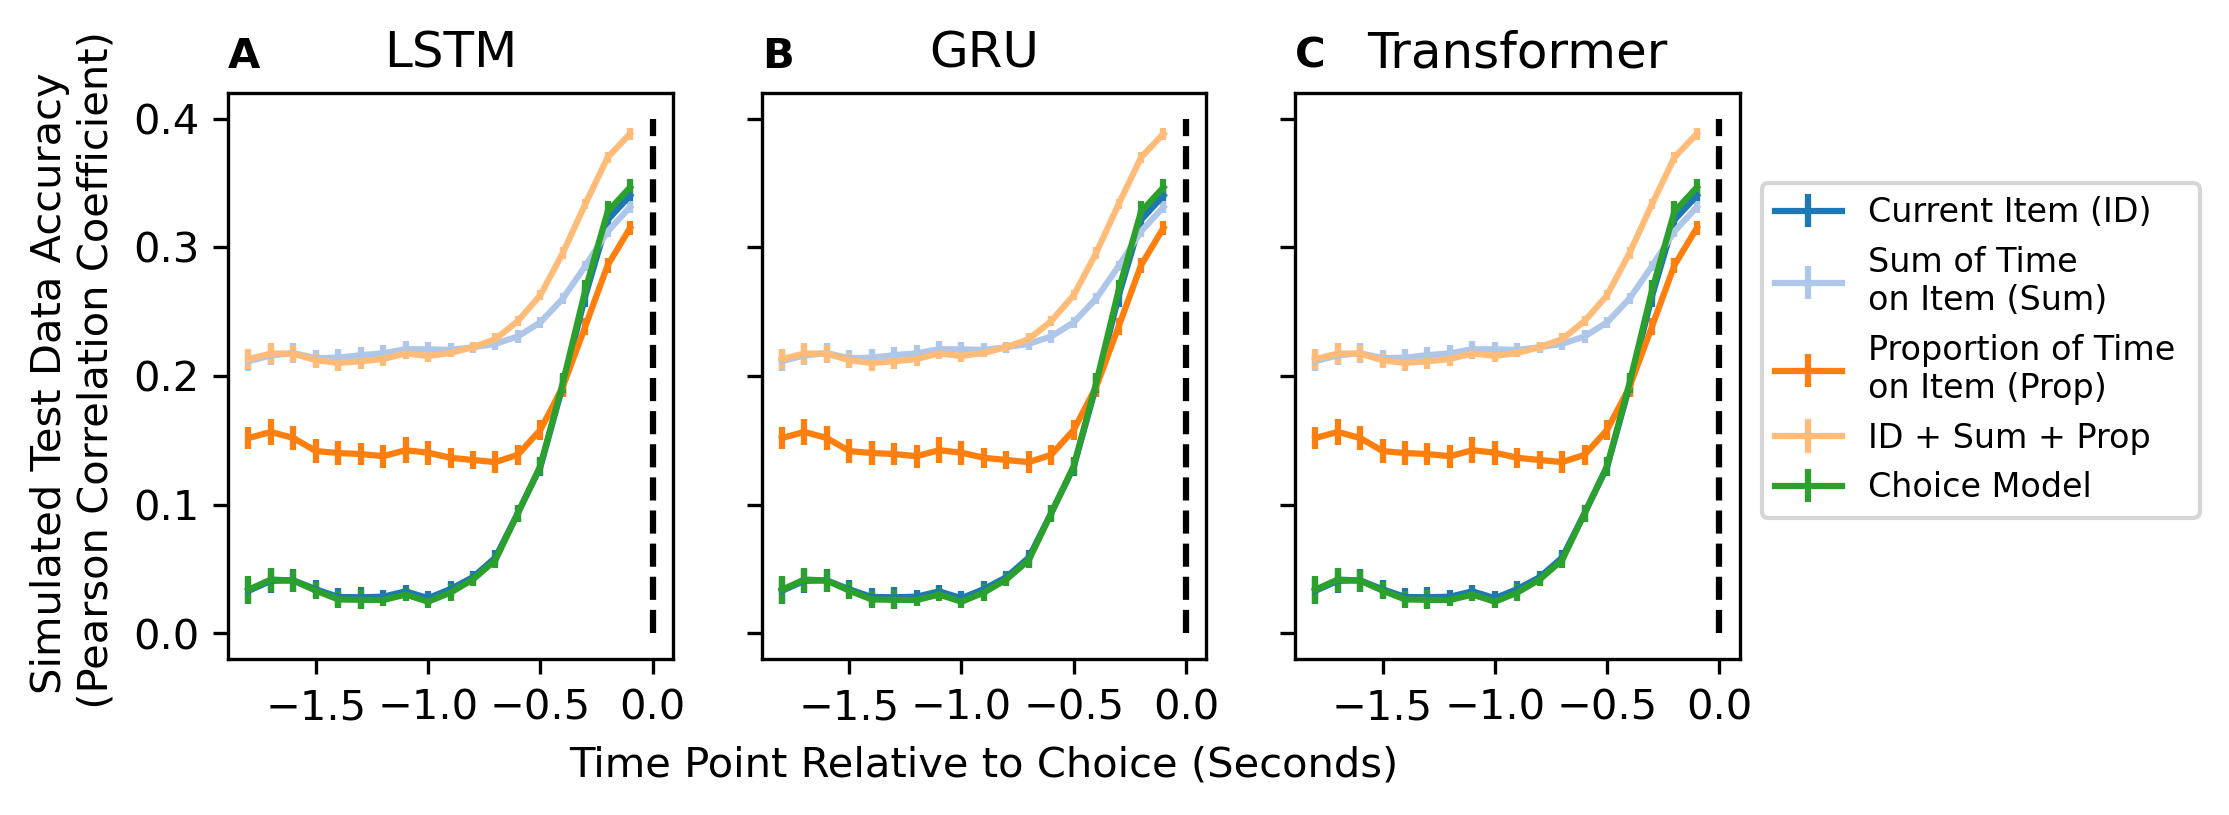

In [7]:
colors = plt.cm.tab20(range(5))
# markers = matplotlib.lines.Line2D.markers.keys()


train_name = train_names[0]

these_fu = ['ID', 'sum', 'prop', 'all']
fu_names = ['Current Item (ID)', 'Sum of Time \non Item (Sum)', 'Proportion of Time \non Item (Prop)', 'ID + Sum + Prop']

fig,ax = plt.subplots(1,3, figsize = (6.5,2.5), dpi = 300, sharex = True, sharey = True)

for model_idx, model_name in enumerate(model_names):
    
    
    # 'fu' results
    # mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, fix_unit = 'all', which_r_sim = 'r_sim_by_n_back', n_runs = 20)
    # these_tps = np.arange(-18,0,1)
    # ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), 'r-', label='fixations + choice')
    # ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = sem_r, label = '{}: All'.format(model_name))
    # ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr = sem_r[:-1], label = '{}: all'.format(model_name))
    

    ax[model_idx].set_title(model_name)
    
    these_tps = np.arange(-18,0,1)/10
    # do the fix_only model...
    
    for fu_idx, fu in enumerate(['ID', 'sum', 'prop', 'all']):
        mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, c_sim_lr, 0, 5e5, 0, c_dropout, which_r_sim = 'r_sim_by_n_back', n_runs = 20)
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = fu_names[fu_idx], color = colors[fu_idx])
    
    # choice then fix... 
    mn_r_by_n_back_c, sem_r_c = get_correlation_results(model_name, train_name, which_r_sim = 'r_sim_by_n_back', choice_then_fix = True, n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = 'Choice Model', color = colors[fu_idx+1])
    ax[model_idx].set_xticks([-1.5, -1, -.5, 0])
    ax[model_idx].vlines(x=[0], ymin=0, ymax=.4, color='k', ls = '--')


ax[2].legend(fontsize=8, loc = (1.05,.25))

# ax[0].set_ylim(0,.8)
ax[0].set_ylabel('Simulated Test Data Accuracy \n (Pearson Correlation Coefficient)');
ax[1].set_xlabel('Time Point Relative to Choice (Seconds)')

labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].set_title(labels[i], loc = 'Left', fontsize = 'medium', weight = 'bold')


plt.savefig("paper_figs/Train_Sim_Test_Sim_All_Models_Control_Models.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("paper_figs/Train_Sim_Test_Sim_All_Models_Control_Models.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)


#### Make Figure 1 for Paper

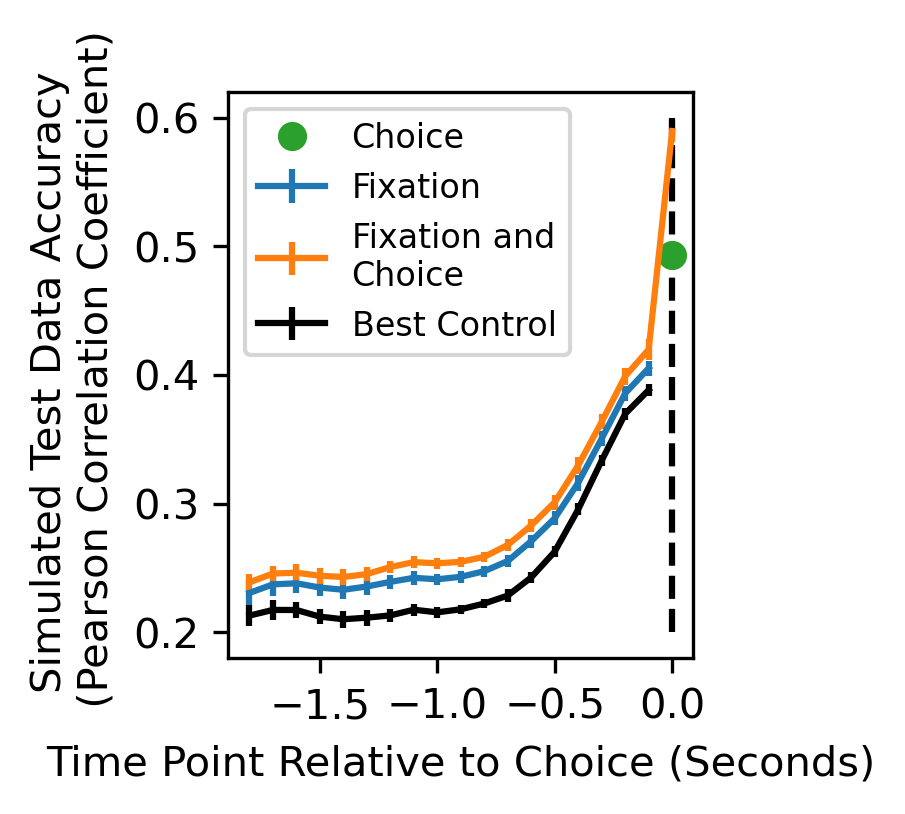

In [8]:
train_name = train_names[0]

fig,ax = plt.subplots(1,figsize = (6/3,2.5), dpi = 300, sharex = True, sharey = True)
ax.set_xlabel('Time Point Relative to Choice (Seconds)')
ax.set_ylabel('Simulated Test Data Accuracy \n (Pearson Correlation Coefficient)');

    
model_name = 'LSTM'



these_tps = np.arange(-18,0,1)/10
mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, train_seq_part = 'fix_only', which_r_sim = 'r_sim_by_n_back', n_runs = 20)
ax.errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr = np.flip(sem_r[:-1]), label = 'Fixation'.format(model_name))

# do the fix_only model...

# choice then fix... 
#mn_r_by_n_back_c, sem_r_c = get_correlation_results(model_name, train_name, which_r_sim = 'r_sim_by_n_back', choice_then_fix = True, n_runs = 20)
#ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c), yerr = sem_r_c, label = 'Fix as choice')

    
# Fixation and Choice Model
mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, which_r_sim = 'r_sim_by_n_back', n_runs = 20)

these_tps = np.arange(-18,1,1)/10
ax.errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = sem_r, label = 'Fixation and\nChoice'.format(model_name))

# get the choice only...
mn_r_by_n_back, sem_r = get_correlation_results('MLP', train_name, which_r_sim = 'r_sim_by_n_back', n_runs = 20, choice_only = True)
ax.plot(0,mn_r_by_n_back,'o', label = 'Choice')
ax.set_xticks([-1.5, -1, -.5, 0])

fu = 'all'
these_tps = np.arange(-18,0,1)/10
mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, c_sim_lr, 0, 5e5, 0, c_dropout, which_r_sim = 'r_sim_by_n_back', n_runs = 20)
ax.errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = 'Best Control', color = 'k', ls='-')


ax.legend(fontsize=8)
ax.vlines(x=[0], ymin=.2, ymax=.6, color='k', ls = '--')


# save this figure...
### Make the plot
plt.savefig("paper_figs/Train_Sim_Test_Sim_LSTM.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("paper_figs/Train_Sim_Test_Sim_LSTM.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)


In [2]:
?plt.letter_subplots

Object `plt.letter_subplots` not found.


In [99]:
mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, fix_unit = 'all', which_r_sim = 'r_sim_by_n_back', n_runs = 20)
np.flip(mn_r_by_n_back)

array([0.24277678, 0.24648743, 0.24832428, 0.24759263, 0.24560618,
       0.24950233, 0.25461   , 0.25715347, 0.2552693 , 0.2565021 ,
       0.25985244, 0.26876592, 0.28317301, 0.30091612, 0.32900469,
       0.36350784, 0.39990541, 0.42013242, 0.58736921])

## Train on simulated data, test on Human data

#### Results for train human / test human and train both

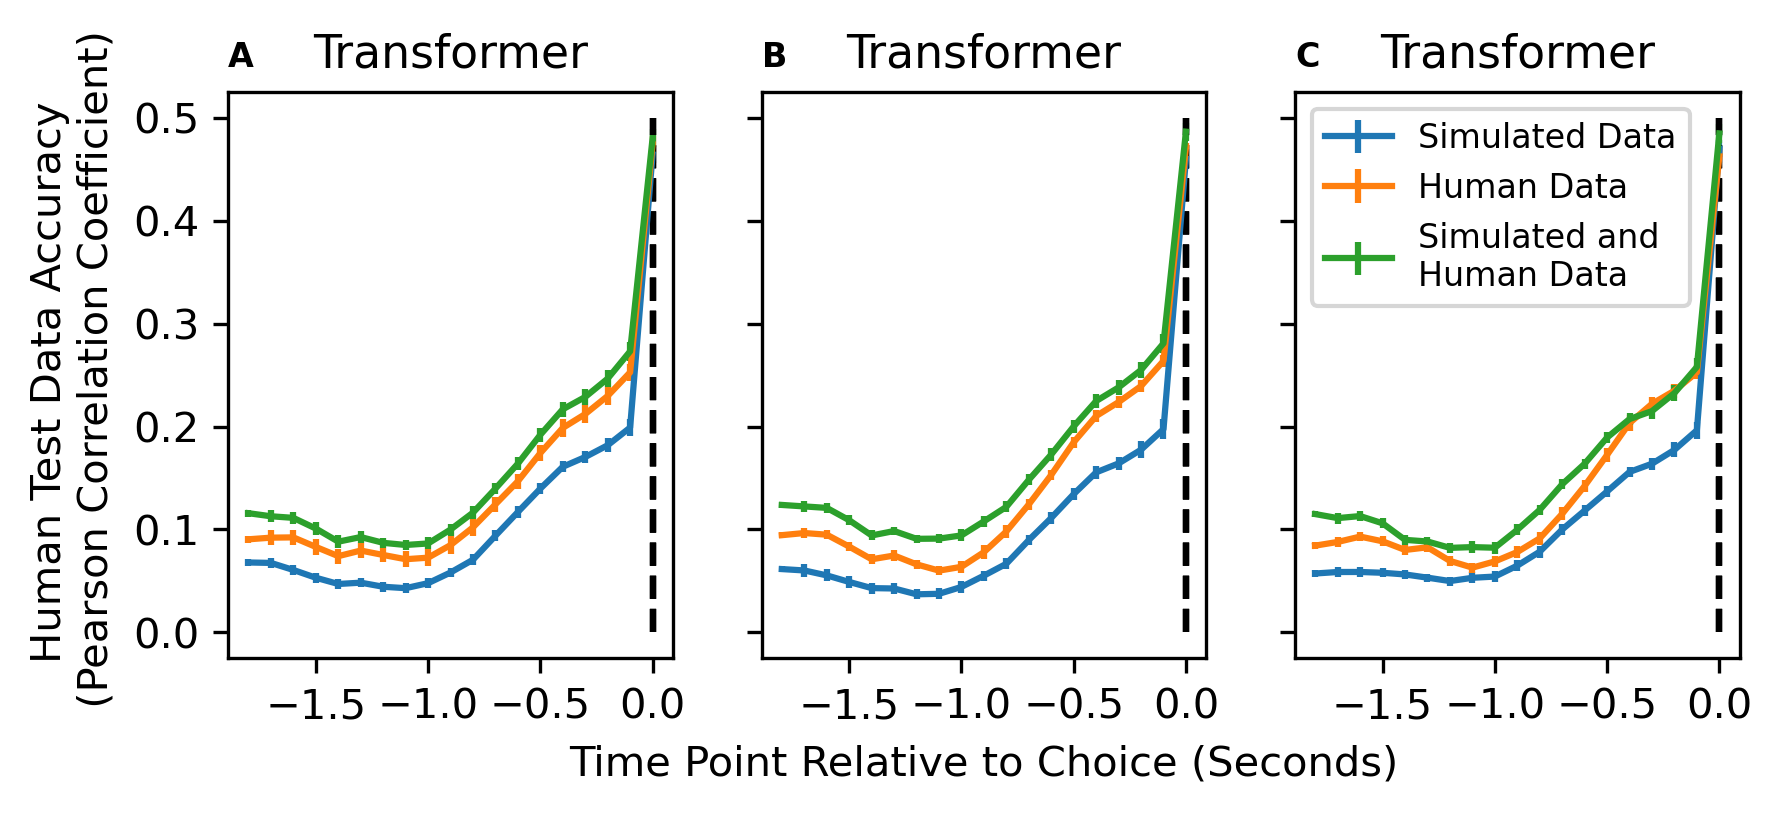

In [9]:
# colors = plt.cm.tab20(range(3))

fig,ax = plt.subplots(1,3, figsize = (6.5,2.5), dpi = 300, sharex = True, sharey = True)

train_labels = ['Simulated Data', 'Human Data', 'Simulated and \nHuman Data']

for train_idx, train_name in enumerate(train_names[1:]):

    for model_idx, model_name in enumerate(model_names):
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name,fix_unit = 'all', which_r_sim = 'r_human_by_n_back', n_runs = 20)

        these_tps = np.arange(-18,1,1)/10
        #ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), label='fixations + choice')
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=sem_r, label = train_labels[train_idx])

        
        ax[model_idx].set_xticks([-1.5, -1, -.5, 0])
        
        ax[model_idx].vlines(x=[0], ymin=0, ymax=.5, color='k', ls = '--')


        # ax[model_idx].legend()
        
        these_tps = np.arange(-18,0,1)
        #for fu in ['ID', 'sum', 'prop']:
        #    mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, c_sim_lr, 0, 5e5, 0, c_dropout, which_r_sim = 'r_human_by_n_back', n_runs = 20)
        #    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c)[:-1], yerr = sem_r_c[:-1], label = 'MLP: '+fu)

for model_idx in range(3):
    ax[model_idx].set_title(model_name, fontsize = 11)

ax[2].legend(fontsize = 8)

ax[0].set_ylabel('Human Test Data Accuracy \n (Pearson Correlation Coefficient)');
ax[1].set_xlabel('Time Point Relative to Choice (Seconds)')

labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].set_title(labels[i], loc = 'Left',  weight = 'bold', fontsize = 8)

plt.savefig("paper_figs/Test_Human_Compare_Pretrain_All_Models.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("paper_figs/Test_Human_Compare_Pretrain_All_Models.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)

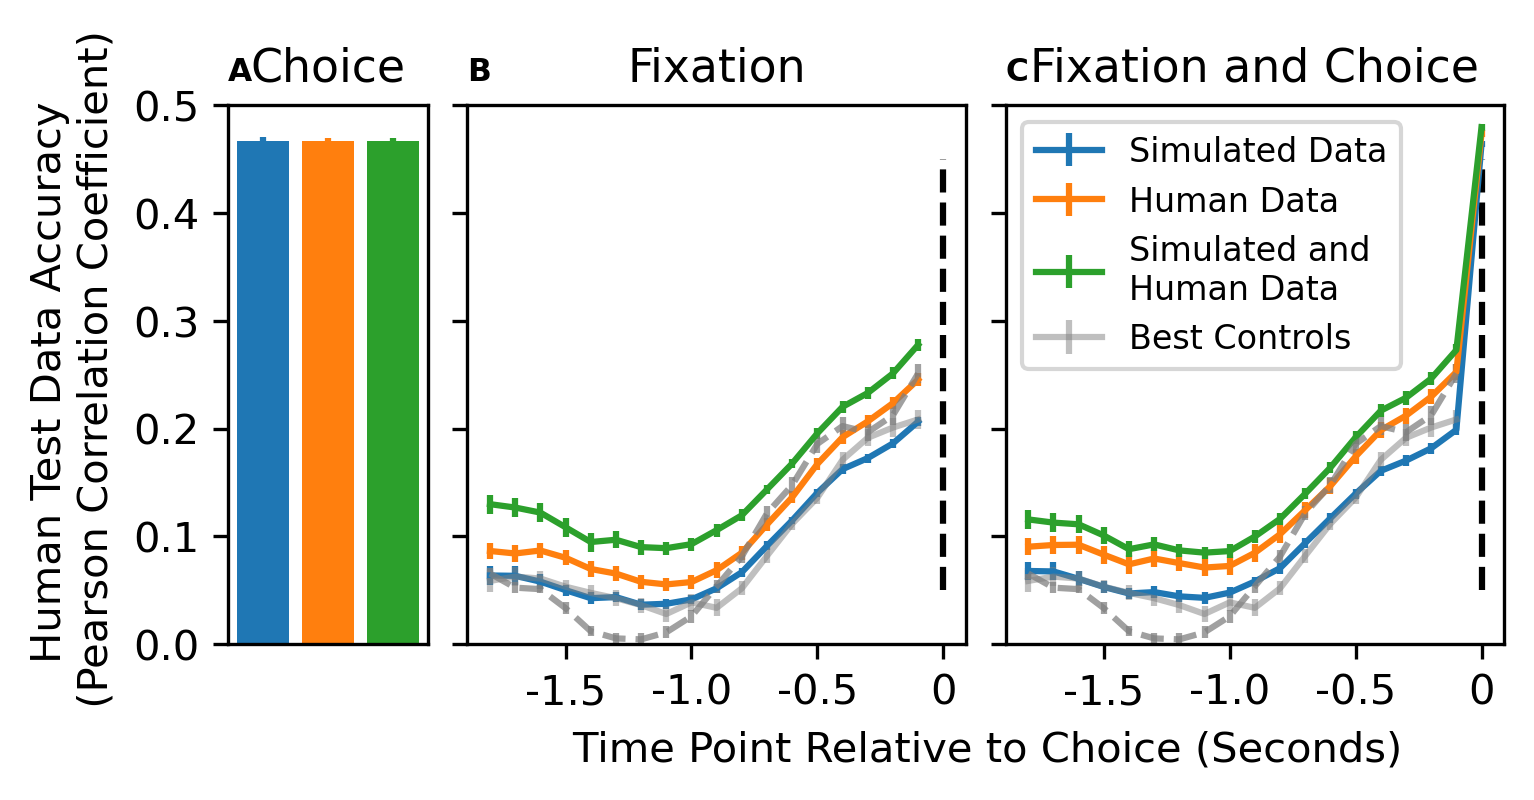

In [48]:

# expand this to show both fix and choice, and also the fix_only...
plot_controls = True


fig,ax = plt.subplots(1, 3, figsize = (5,2.5), dpi = 300, sharey = True, constrained_layout=True, gridspec_kw={
    "width_ratios": [.4, 1, 1]})

train_labels = ['Simulated Data', 'Human Data', 'Simulated and \nHuman Data']
titles = ['Choice', 'Fixation', 'Fixation and Choice']


for train_idx, train_name in enumerate(train_names[1:]):

    for model_idx, model_name in enumerate(['LSTM']):
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, train_seq_part = 'fix_only', fix_unit= 'all', which_r_sim = 'r_human_by_n_back', n_runs = 20)

        these_tps = np.arange(-18,0,1)/10
        ax[1].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr=np.flip(sem_r[:-1]), label = train_labels[train_idx])
        
        
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, train_seq_part = 'fix_and_choice', fix_unit= 'all', which_r_sim = 'r_human_by_n_back', n_runs = 20)

        these_tps = np.arange(-18,1,1)/10
        ax[2].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=np.flip(sem_r), label = train_labels[train_idx])
        
        mn_r_by_n_back, sem_r = get_correlation_results('MLP', train_name, choice_only = True, which_r_sim = 'r_human_by_n_back', n_runs = 20)
        ax[0].bar(train_idx, mn_r_by_n_back)
        ax[0].errorbar(train_idx, mn_r_by_n_back, yerr = sem_r)


if plot_controls:
    these_tps = np.arange(-18,0,1)/10
    for ax_idx in range(1,3):
        for fu in ['prop']: # check that this doesn't matter
            mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, c_sim_lr, 0, 5e5, 0, c_dropout, which_r_sim = 'r_human_by_n_back', n_runs = 20)
            ax[ax_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = 'Best Controls',  color = 'gray', ls = '-', alpha = .5)

            
        these_tps = np.arange(-18,0,1)/10
        # choice_then_fix
        mn_r_by_n_back_c, sem_r_c = get_correlation_results(model_name, train_names[3], which_r_sim = 'r_human_by_n_back', choice_then_fix = True, n_runs = 20)
        ax[ax_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = sem_r_c[:-1], color = 'gray', ls = '--', alpha = .75)

for ax_idx in range(1,3):
    ax[ax_idx].vlines(x=[0], ymin=.05, ymax=.45, color='k', ls = '--', alpha = 1)
    ax[ax_idx].set_xticks([-1.5, -1., -.5, 0])
    ax[ax_idx].set_xticklabels([-1.5, -1., -.5, 0])

    
for ax_idx in range(3):
    ax[ax_idx].set_title(titles[ax_idx], fontsize = 11)
    ax[ax_idx].set_ylim(0,.5)
    
ax[0].set_xticks([])
ax[1].set_xlabel('        Time Point Relative to Choice (Seconds)', loc = 'left')
# fig.supxlabel('Time Point Relative to Choice (Seconds)', fontsize=9)

ax[2].legend(fontsize = 8)

ax[0].set_ylabel('Human Test Data Accuracy \n (Pearson Correlation Coefficient)');

labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].set_title(labels[i], loc = 'Left', weight = 'bold', fontsize = 7.5)

if plot_controls:
    plt.savefig("paper_figs/Test_Human_Compare_Pretrain_LSTM_All_w_Controls.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
    plt.savefig("paper_figs/Test_Human_Compare_Pretrain_LSTM_All_w_Controls.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)
else:
    plt.savefig("paper_figs/Test_Human_Compare_Pretrain_LSTM_All.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
    plt.savefig("paper_figs/Test_Human_Compare_Pretrain_LSTM_All.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)

# do the choice only...

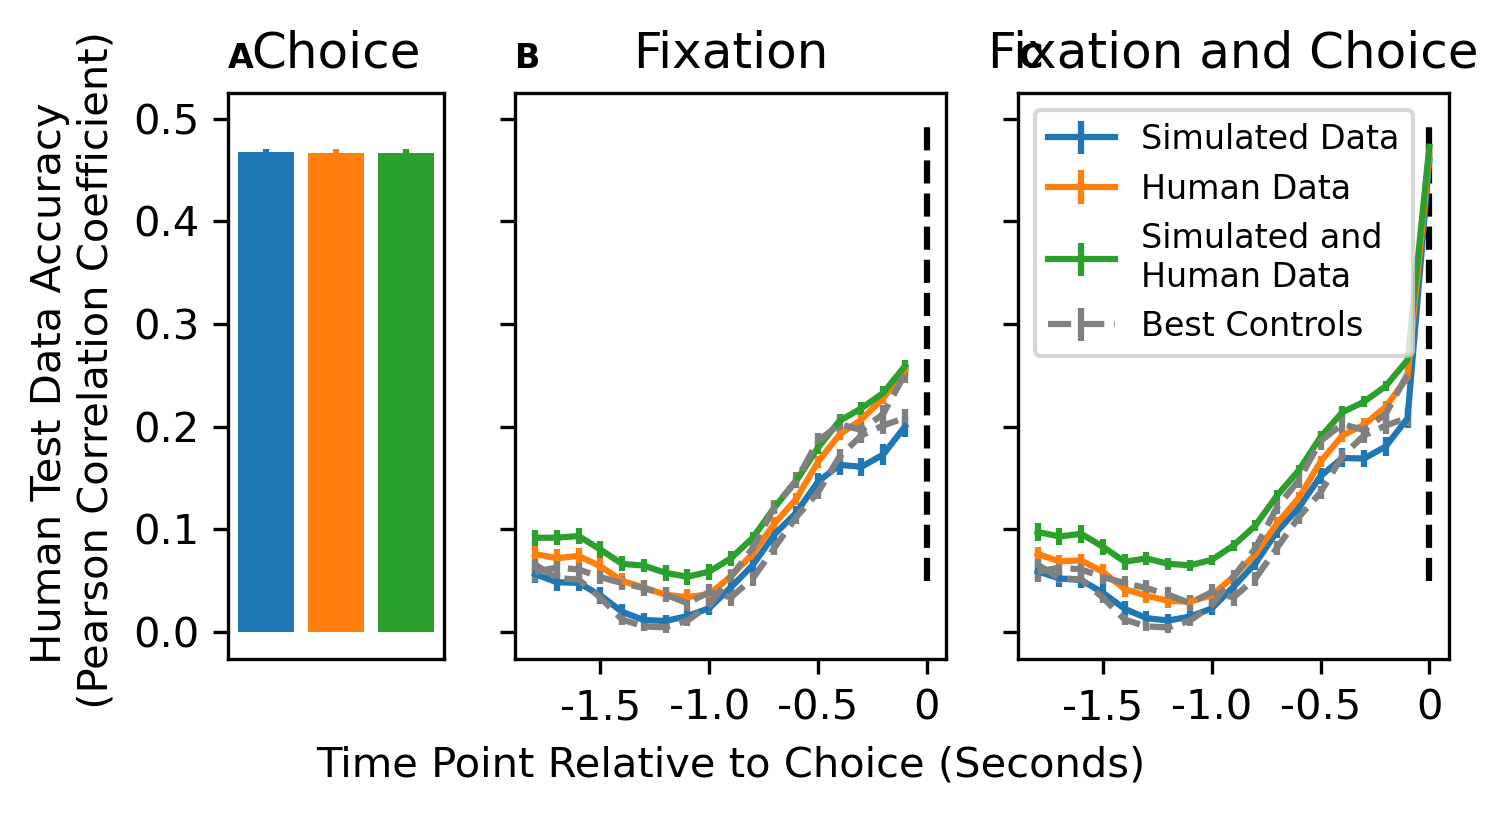

In [12]:
plot_controls = True

# expand this to show both fix and choice, and also the fix_only...

fig,ax = plt.subplots(1, 3, figsize = (5.25,2.5), dpi = 300, sharey = True, constrained_layout=False, gridspec_kw={
    "width_ratios": [1, 2, 2]})

train_labels = ['Simulated Data', 'Human Data', 'Simulated and \nHuman Data']
titles = ['Choice', 'Fixation', 'Fixation and Choice']


for train_idx, train_name in enumerate(train_names[1:]):

    for model_idx, model_name in enumerate(['LSTM']):
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, train_seq_part = 'fix_only', fix_unit= 'ID', which_r_sim = 'r_human_by_n_back', n_runs = 20)

        these_tps = np.arange(-18,0,1)/10
        ax[1].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr=np.flip(sem_r[:-1]), label = train_labels[train_idx])
        
        
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, train_seq_part = 'fix_and_choice', fix_unit= 'ID', which_r_sim = 'r_human_by_n_back', n_runs = 20)

        these_tps = np.arange(-18,1,1)/10
        ax[2].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=np.flip(sem_r), label = train_labels[train_idx])
        
        mn_r_by_n_back, sem_r = get_correlation_results('MLP', train_name, choice_only = True, which_r_sim = 'r_human_by_n_back', n_runs = 20)
        

        ax[0].bar(train_idx, mn_r_by_n_back)
        ax[0].errorbar(train_idx, mn_r_by_n_back, yerr = sem_r)

if plot_controls:
    these_tps = np.arange(-18,0,1)/10
    for ax_idx in range(1,3):
        for fu in ['prop']: # check that this doesn't matter
            mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, c_sim_lr, 0, 5e5, 0, c_dropout, which_r_sim = 'r_human_by_n_back', n_runs = 20)
            ax[ax_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = 'Best Controls',  color = 'gray', ls = '--')

            
        these_tps = np.arange(-18,0,1)/10
        # choice_then_fix
        mn_r_by_n_back_c, sem_r_c = get_correlation_results(model_name, train_names[3], which_r_sim = 'r_human_by_n_back', choice_then_fix = True, n_runs = 20)
        ax[ax_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = sem_r_c[:-1], color = 'gray', ls = '--')

for ax_idx in range(1,3):
    ax[ax_idx].vlines(x=[0], ymin=.05, ymax=.5, color='k', ls = '--')
    ax[ax_idx].set_xticks([-1.5, -1., -.5, 0])
    ax[ax_idx].set_xticklabels([-1.5, -1., -.5, 0])

for ax_idx in range(3):
    ax[ax_idx].set_title(titles[ax_idx])


labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].set_title(labels[i], loc = 'Left', weight = 'bold', fontsize = 8)
    
ax[0].set_xticks([])
ax[1].set_xlabel('Time Point Relative to Choice (Seconds)')
# fig.supxlabel('Time Point Relative to Choice (Seconds)', fontsize=9)

ax[2].legend(fontsize = 8)

ax[0].set_ylabel('Human Test Data Accuracy \n (Pearson Correlation Coefficient)');
plt.savefig("paper_figs/Test_Human_Compare_Pretrain_LSTM_ID.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("paper_figs/Test_Human_Compare_Pretrain_LSTM_ID.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)

# do the choice only...

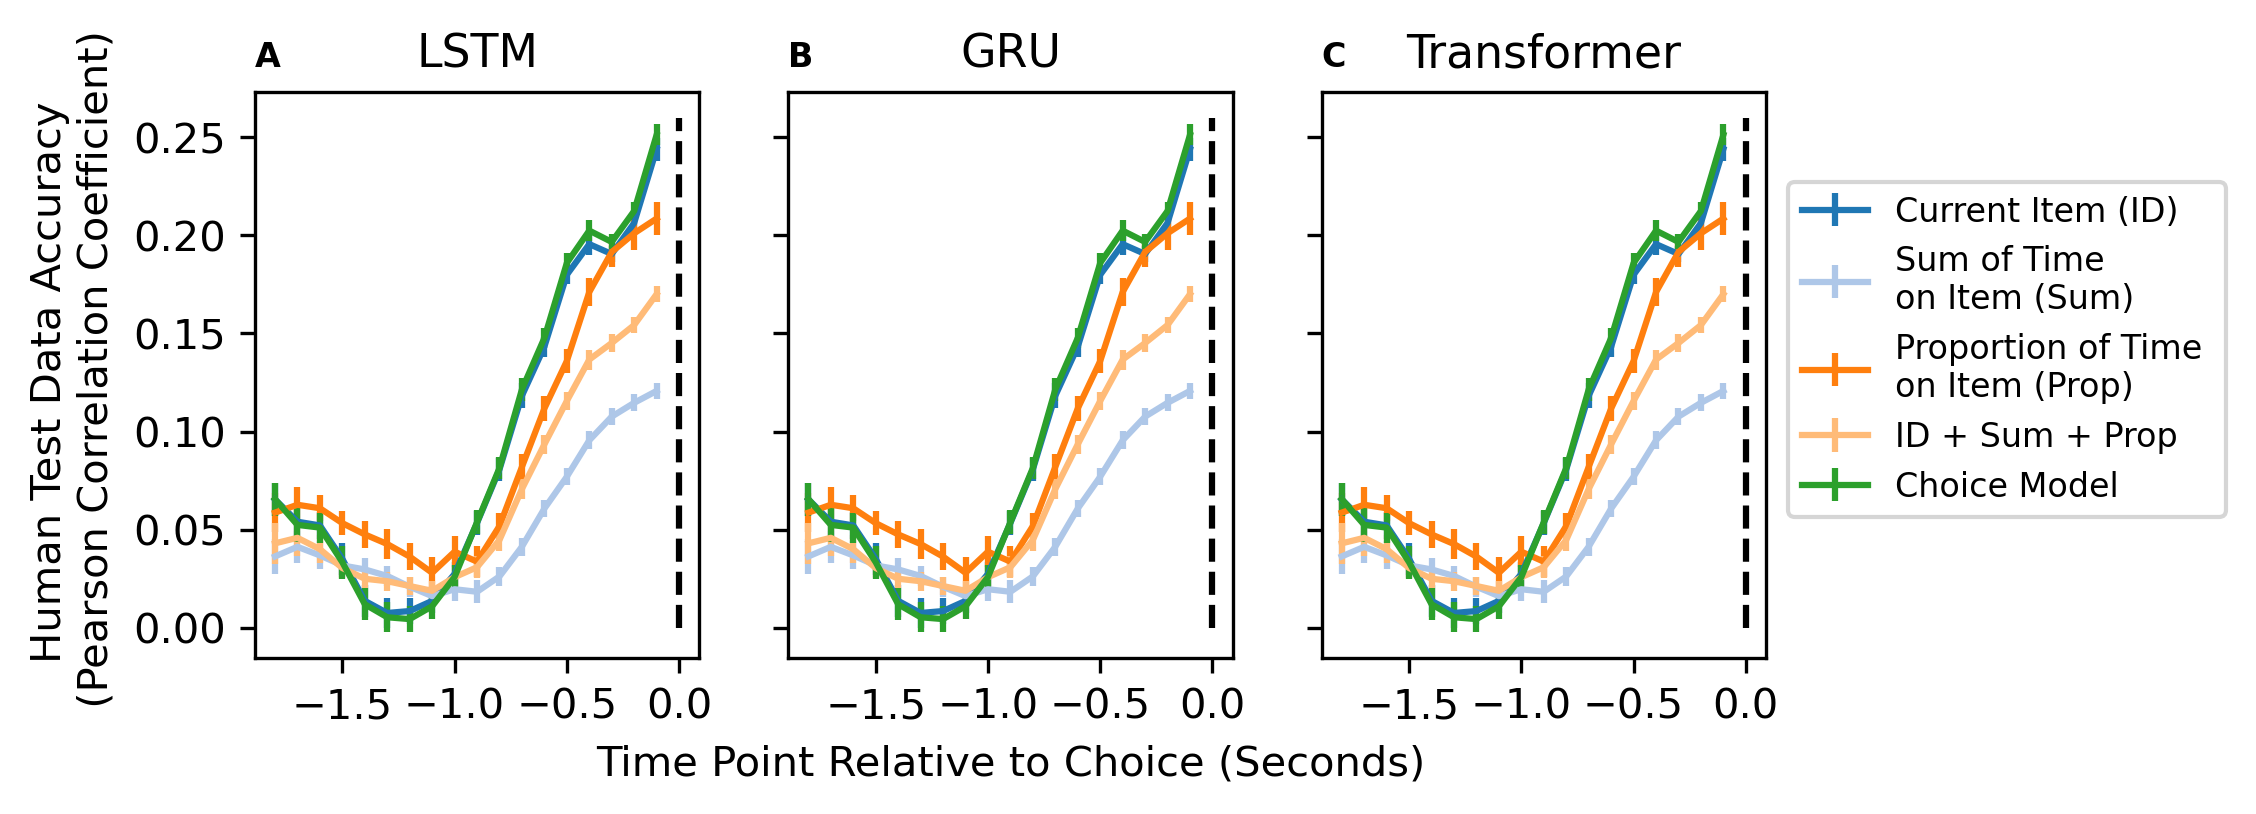

In [17]:
colors = plt.cm.tab20(range(5))
# markers = matplotlib.lines.Line2D.markers.keys()


these_fu = ['ID', 'sum', 'prop', 'all']
fu_names = ['Current Item (ID)', 'Sum of Time \non Item (Sum)', 'Proportion of Time \non Item (Prop)', 'ID + Sum + Prop']

fig,ax = plt.subplots(1,3, figsize = (6.5,2.5), dpi = 300, sharex = True, sharey = True)

for model_idx, model_name in enumerate(model_names):
    
    #these_tps = np.arange(-18,1,1)/10

    #mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[3], which_r_sim = 'r_human_by_n_back', n_runs = 20)
    #ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = np.flip(sem_r), label = 'Fixation and Choice', color = 'k')


    ax[model_idx].set_title(model_name, fontsize = 11)
    
    these_tps = np.arange(-18,0,1)/10
    # do the fix_only model...
    
    for fu_idx, fu in enumerate(['ID', 'sum', 'prop', 'all']):
        mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, c_sim_lr, 0, 5e5, 0, c_dropout, which_r_sim = 'r_human_by_n_back', n_runs = 20)
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = fu_names[fu_idx], color = colors[fu_idx])
    
    # choice then fix... 
    mn_r_by_n_back_c, sem_r_c = get_correlation_results(model_name, train_names[3], which_r_sim = 'r_human_by_n_back', choice_then_fix = True, n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = 'Choice Model', color = colors[fu_idx+1])
    ax[model_idx].set_xticks([-1.5, -1, -.5, 0])
    ax[model_idx].vlines(x=[0], ymin=0, ymax=.26, color='k', ls = '--')


ax[2].legend(fontsize=8, loc = (1.05,.25))

# ax[0].set_ylim(0,.8)
ax[0].set_ylabel('Human Test Data Accuracy \n (Pearson Correlation Coefficient)');
ax[1].set_xlabel('Time Point Relative to Choice (Seconds)')

labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].set_title(labels[i], loc = 'Left', weight = 'bold', fontsize = 8)

plt.savefig("paper_figs/Test_Human_All_Models_Control_Models.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("paper_figs/Test_Human_All_Models_Control_Models.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)


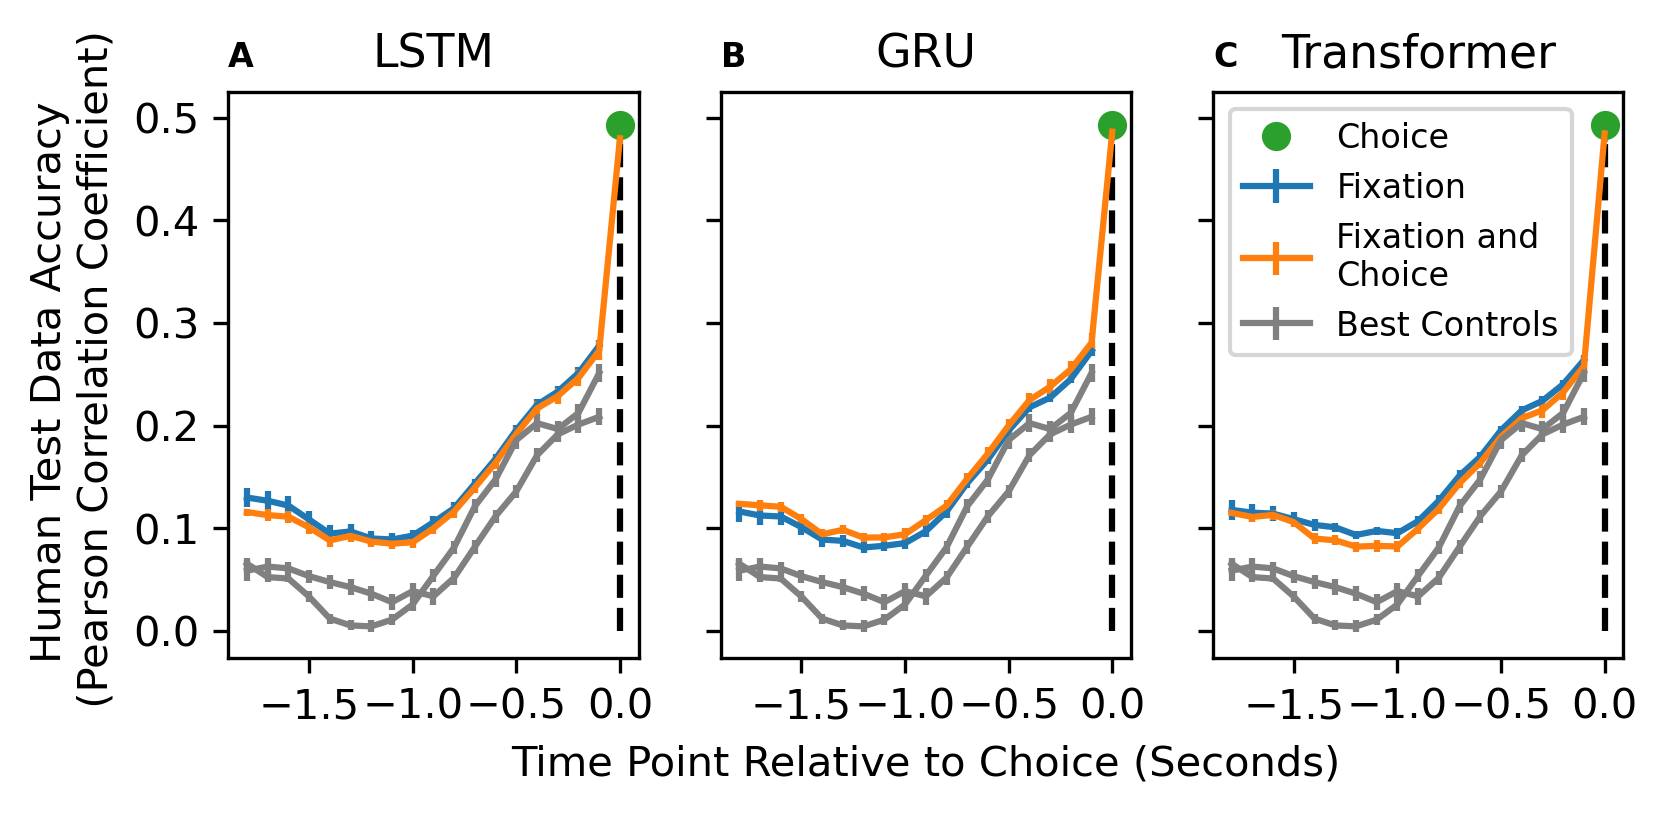

In [37]:
colors = plt.cm.tab20(range(4))


fig,ax = plt.subplots(1,3, figsize = (6,2.5), dpi = 300, sharex = True, sharey = True)

for model_idx, model_name in enumerate(model_names):
    
    
    # 'fu' results
    # mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, fix_unit = 'all', which_r_sim = 'r_sim_by_n_back', n_runs = 20)
    # these_tps = np.arange(-18,0,1)
    # ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), 'r-', label='fixations + choice')
    # ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = sem_r, label = '{}: All'.format(model_name))
    # ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr = sem_r[:-1], label = '{}: all'.format(model_name))
    

    ax[model_idx].set_title(model_name, fontsize = 11)
    
    these_tps = np.arange(-18,0,1)/10
    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[3], train_seq_part = 'fix_only', fix_unit = 'all', which_r_sim = 'r_human_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr = np.flip(sem_r[:-1]), label = 'Fixation'.format(model_name))
    
    # general ID results sequential
    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[3],fix_unit = 'all', which_r_sim = 'r_human_by_n_back', n_runs = 20)
    
    these_tps = np.arange(-18,1,1)/10
    # ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), 'r-', label='fixations + choice')
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = sem_r, label = 'Fixation and \nChoice'.format(model_name))

    # do the fix_only model...
    
    these_tps = np.arange(-18,0,1)/10
    # choice_then_fix
    mn_r_by_n_back_c, sem_r_c = get_correlation_results(model_name, train_names[3], which_r_sim = 'r_human_by_n_back', choice_then_fix = True, n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = sem_r_c[:-1], color = 'gray')

    
        
    # get the choice only...
    mn_r_by_n_back, sem_r = get_correlation_results('MLP', train_names[3], which_r_sim = 'r_sim_by_n_back', n_runs = 20, choice_only = True)
    ax[model_idx].plot(0,mn_r_by_n_back,'o', label = 'Choice')
    
    ax[model_idx].set_xticks([-1.5, -1, -.5, 0])

    ax[model_idx].vlines(x=[0], ymin=0, ymax=.5, color='k', ls = '--')
    


    these_tps = np.arange(-18,0,1)/10
    for fu in ['prop']: # check that this doesn't matter
        mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, c_sim_lr, 0, 5e5, 0, c_dropout, which_r_sim = 'r_human_by_n_back', n_runs = 20)
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = 'Best Controls',  color = 'gray')


    # ax[model_idx].errorbar(0,mn_r_by_n_back,yerr = sem_r, label = 'Choice Only')

ax[2].legend(fontsize=8)

ax[0].set_ylabel('Human Test Data Accuracy \n (Pearson Correlation Coefficient)');
ax[1].set_xlabel('Time Point Relative to Choice (Seconds)')

labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].set_title(labels[i], loc = 'Left', weight = 'bold', fontsize = 8)
    
### Make the plot
# plt.savefig("paper_figs/Train_Sim_Test_Sim_All_Models.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
# plt.savefig("paper_figs/Train_Sim_Test_Sim_All_Models.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)

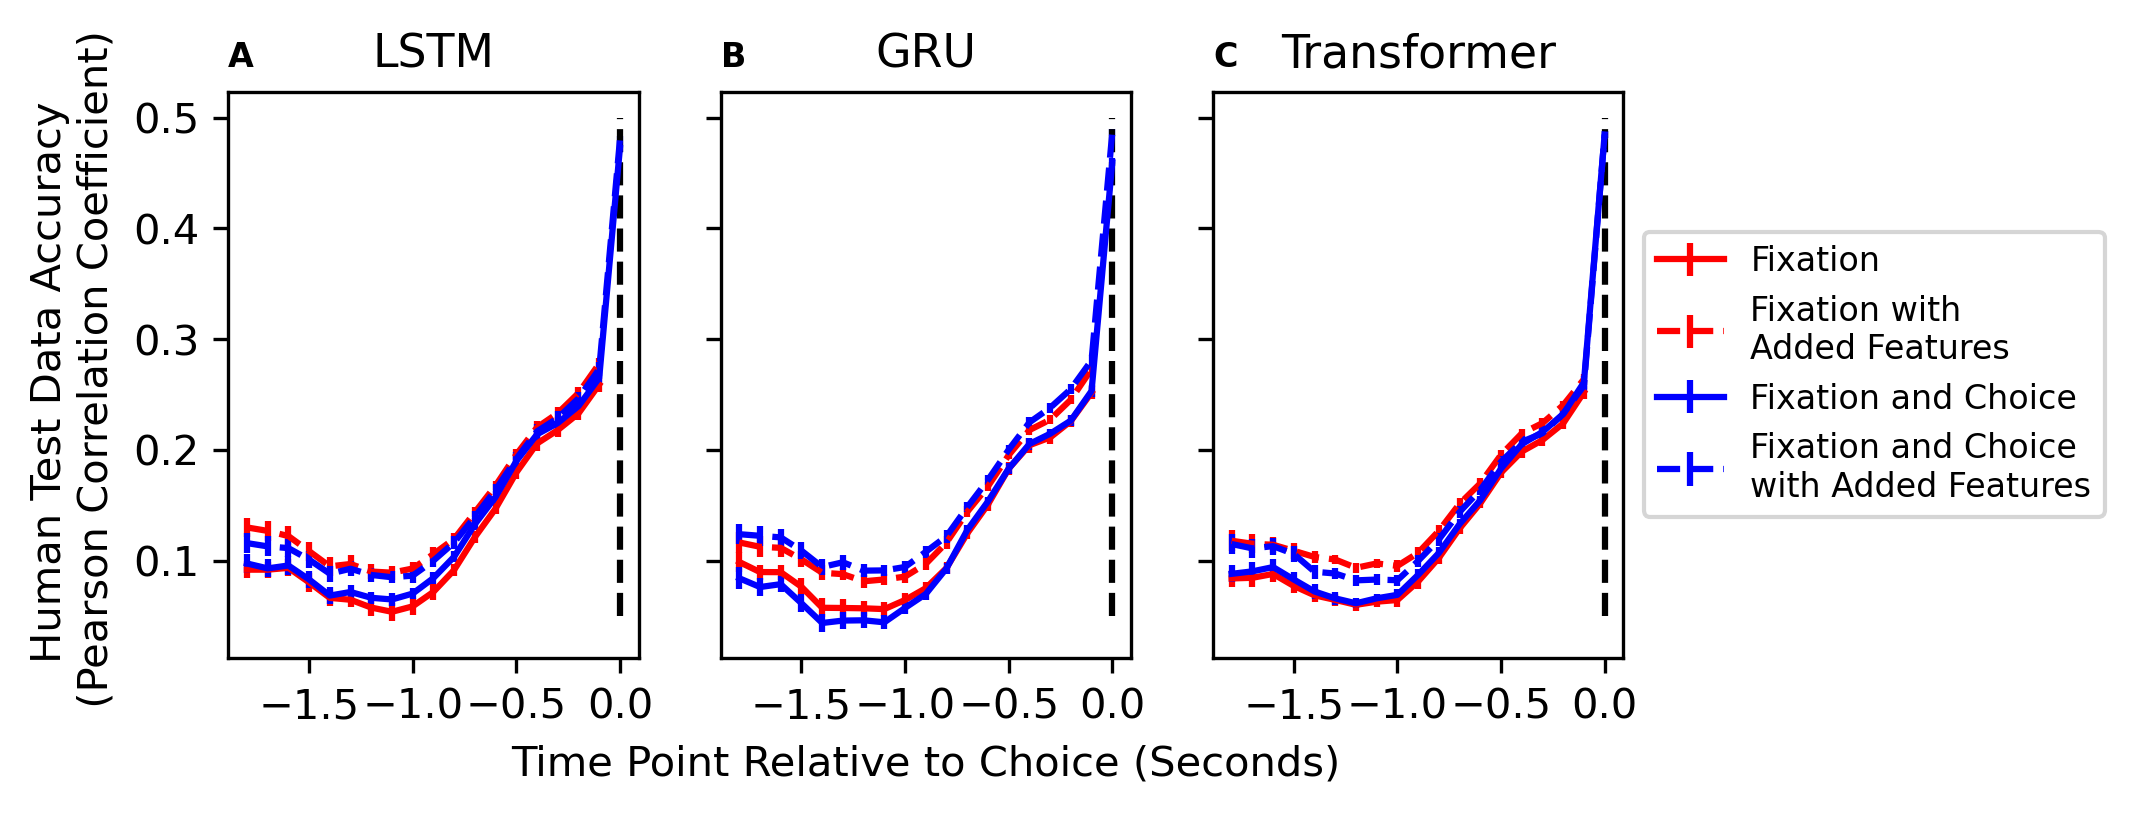

In [40]:
colors = plt.cm.tab20(range(4))


fig,ax = plt.subplots(1,3, figsize = (6,2.5), dpi = 300, sharex = True, sharey = True)


for model_idx, model_name in enumerate(model_names):

    #for train_seq_part in ['fix_only', 'fix_and_choice']:
    
    ax[model_idx].set_title(model_name, fontsize = 11)
    
    train_seq_part = 'fix_only'

    these_tps = np.arange(-18,0,1)/10
    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[3], train_seq_part = train_seq_part, which_r_sim = 'r_human_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr = np.flip(sem_r[:-1]), label = 'Fixation', color = 'r')

    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[3], fix_unit = 'all', train_seq_part = train_seq_part, which_r_sim = 'r_human_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr = np.flip(sem_r[:-1]), label = 'Fixation with \nAdded Features', ls = '--', color = 'r')
    
    train_seq_part = 'fix_and_choice'

    these_tps = np.arange(-18,1,1)/10
    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[3], train_seq_part = train_seq_part, which_r_sim = 'r_human_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = np.flip(sem_r), label = 'Fixation and Choice', color = 'b')

    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[3], fix_unit = 'all', train_seq_part = train_seq_part, which_r_sim = 'r_human_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = np.flip(sem_r), label = 'Fixation and Choice \nwith Added Features', ls='--', color = 'b')

    ax[model_idx].vlines(x=[0], ymin=.05, ymax=.5, color='k', ls = '--')
    ax[model_idx].set_xticks([-1.5, -1, -.5, 0])

    # ax[model_idx].errorbar(0,mn_r_by_n_back,yerr = sem_r, label = 'Choice Only')

ax[2].legend(fontsize=8,loc = (1.05,.25))

ax[0].set_ylabel('Human Test Data Accuracy \n (Pearson Correlation Coefficient)');
ax[1].set_xlabel('Time Point Relative to Choice (Seconds)')

labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].set_title(labels[i], loc = 'Left', weight = 'bold', fontsize = 8)

### Make the plot
plt.savefig("paper_figs/Benefit_of_Features_All_Models_Human_Data.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("paper_figs/Benefit_of_Features_All_Models_Human_Data.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)

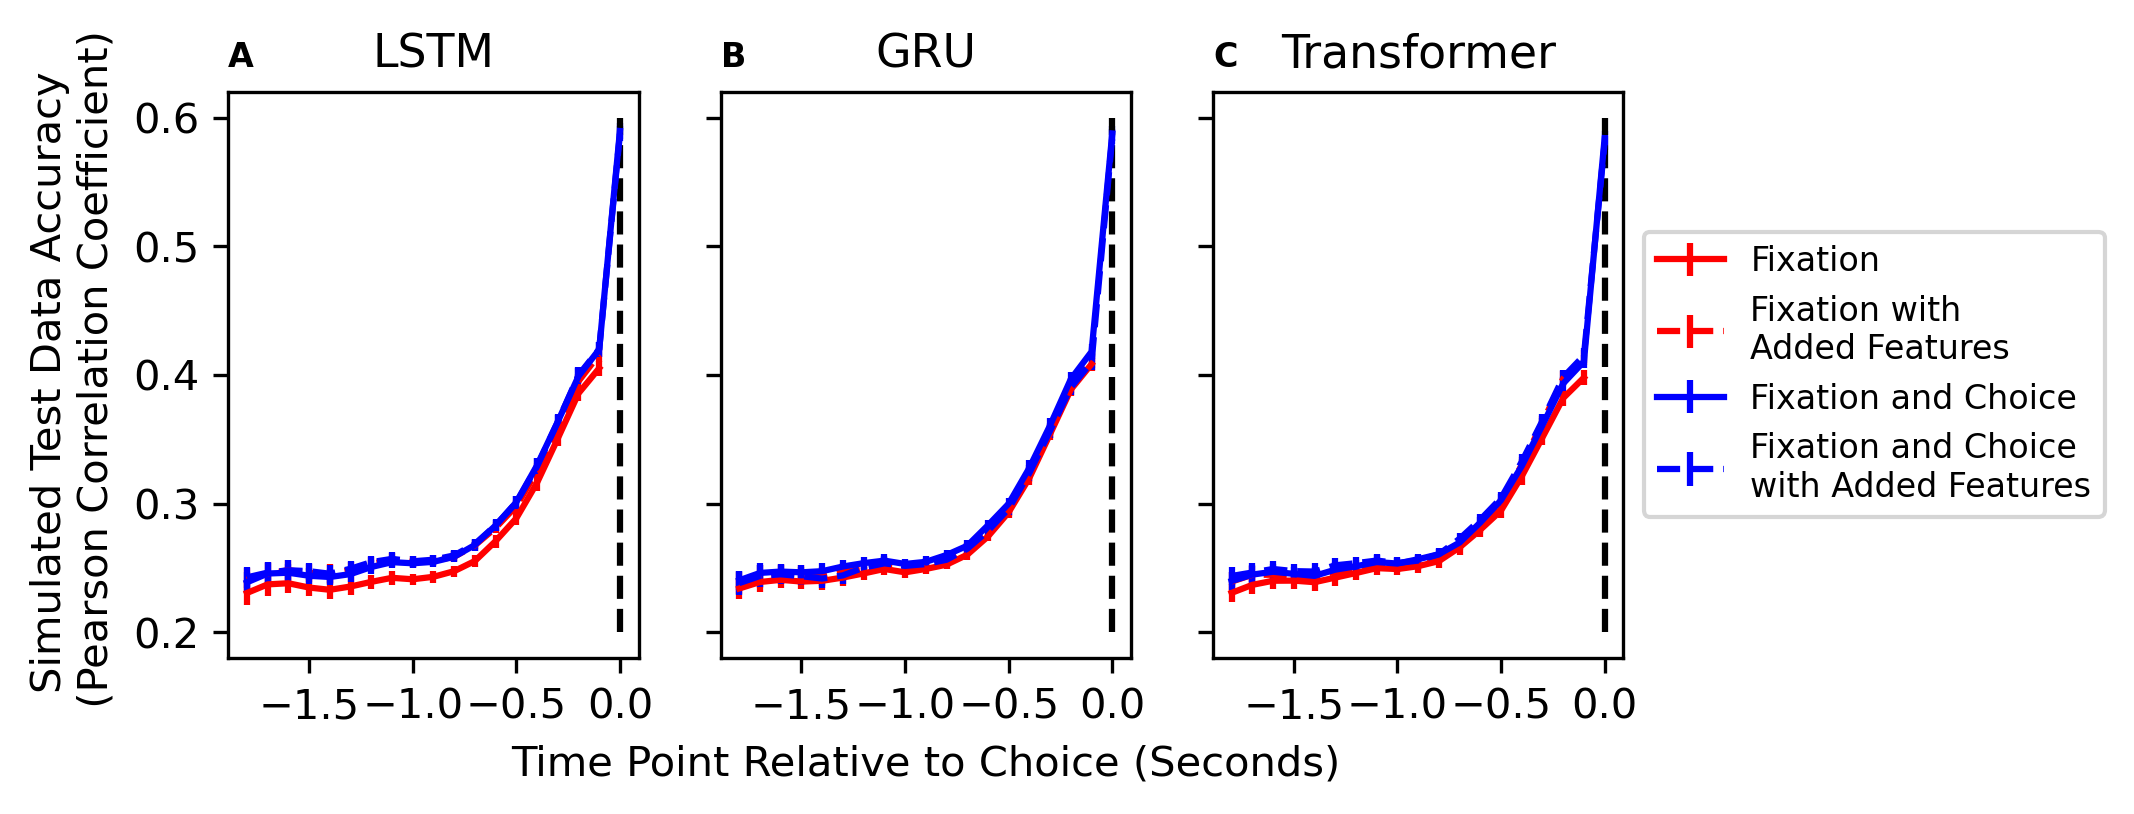

In [45]:
colors = plt.cm.tab20(range(4))


fig,ax = plt.subplots(1,3, figsize = (6,2.5), dpi = 300, sharex = True, sharey = True)


for model_idx, model_name in enumerate(model_names):

    #for train_seq_part in ['fix_only', 'fix_and_choice']:
    
    ax[model_idx].set_title(model_name, fontsize = 11)
    
    train_seq_part = 'fix_only'

    these_tps = np.arange(-18,0,1)/10
    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[0], train_seq_part = train_seq_part, which_r_sim = 'r_sim_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr = np.flip(sem_r[:-1]), label = 'Fixation', color = 'r')

    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[0], fix_unit = 'all', train_seq_part = train_seq_part, which_r_sim = 'r_sim_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back[:-1]), yerr = np.flip(sem_r[:-1]), label = 'Fixation with \nAdded Features', ls = '--', color = 'r')
    
    train_seq_part = 'fix_and_choice'

    these_tps = np.arange(-18,1,1)/10
    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[0], train_seq_part = train_seq_part, which_r_sim = 'r_sim_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = np.flip(sem_r), label = 'Fixation and Choice', color = 'b')

    mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_names[0], fix_unit = 'all', train_seq_part = train_seq_part, which_r_sim = 'r_sim_by_n_back', n_runs = 20)
    ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = np.flip(sem_r), label = 'Fixation and Choice \nwith Added Features', ls='--', color = 'b')

    ax[model_idx].vlines(x=[0], ymin=.2, ymax=.6, color='k', ls = '--')
    ax[model_idx].set_xticks([-1.5, -1, -.5, 0])

    # ax[model_idx].errorbar(0,mn_r_by_n_back,yerr = sem_r, label = 'Choice Only')

ax[2].legend(fontsize=8,loc = (1.05,.25))

ax[0].set_ylabel('Simulated Test Data Accuracy \n (Pearson Correlation Coefficient)');
ax[1].set_xlabel('Time Point Relative to Choice (Seconds)')

labels = ['A', 'B', 'C']
for i in range(3):
    ax[i].set_title(labels[i], loc = 'Left', weight = 'bold', fontsize = 8)

### Make the plot
plt.savefig("paper_figs/Benefit_of_Features_All_Models_Sim_Data.svg", format='svg', transparent=True,  bbox_inches='tight',pad_inches=0)
plt.savefig("paper_figs/Benefit_of_Features_All_Models_Sim_Data.png", format='png', transparent=True,  bbox_inches='tight',pad_inches=0)

In [42]:
train_names

['train_sim_test_sim',
 'train_sim_test_human',
 'train_human_test_human',
 'train_sim_human_test_human']

Seq Choice Time Pred:  0.4725932401036691
Choice only pred:  0.4667760381978884
Seq Choice Time Pred:  0.4596921371752698
Choice only pred:  0.4667760381978884
Seq Choice Time Pred:  0.48477940177734863
Choice only pred:  0.4667760381978884


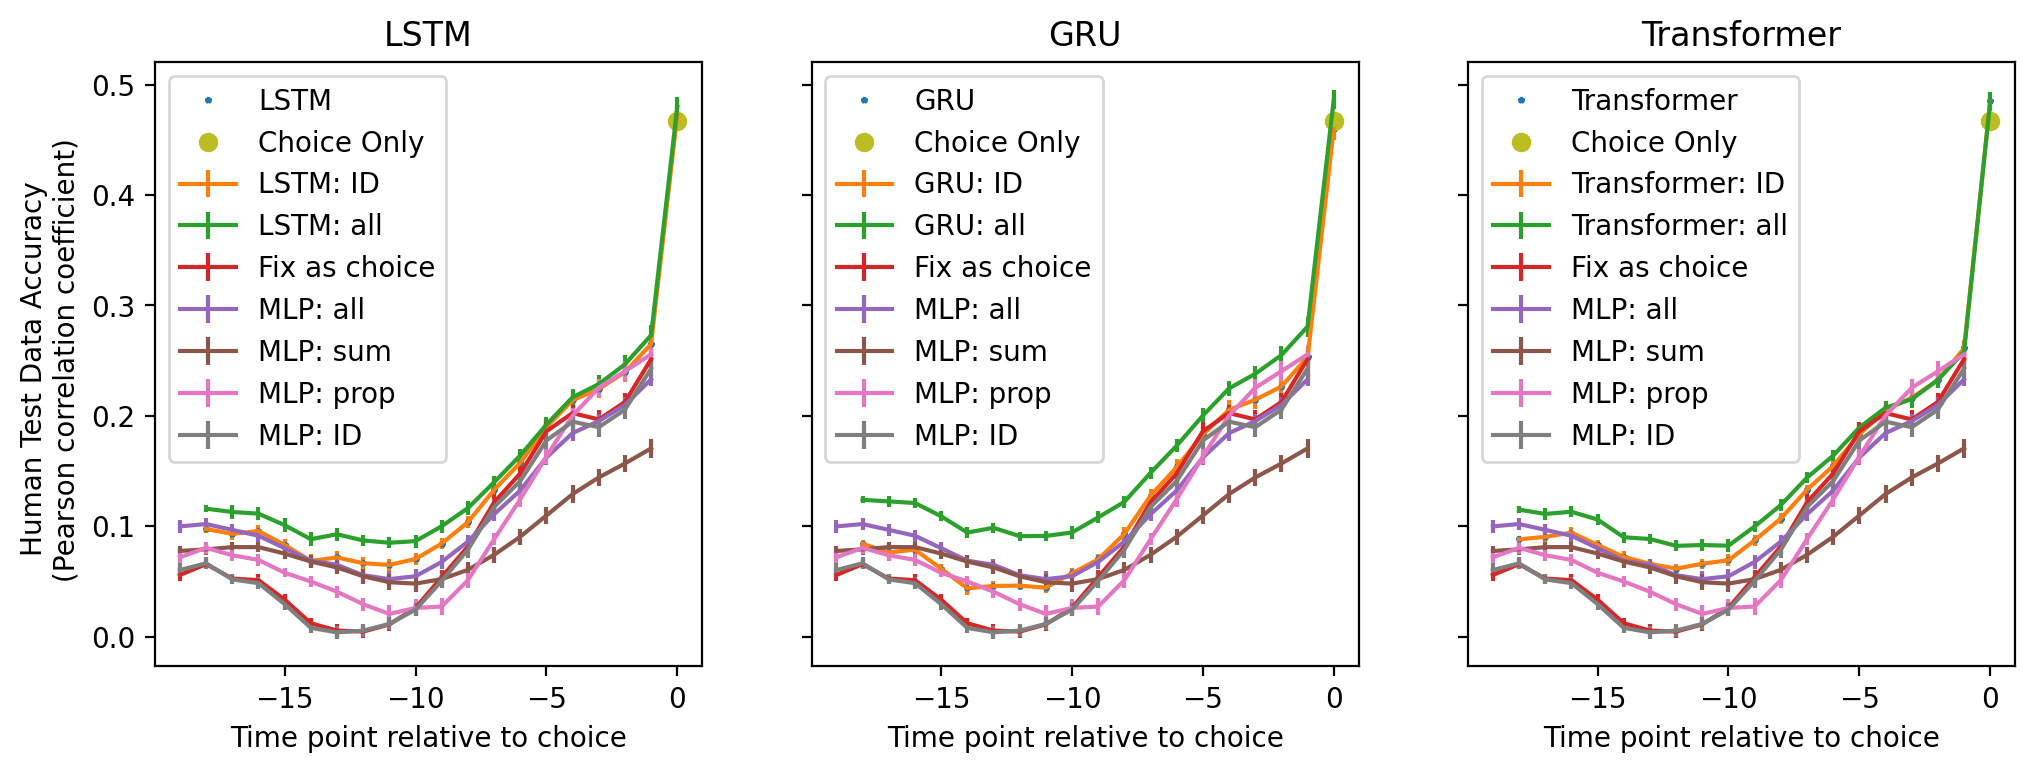

In [37]:
fig,ax = plt.subplots(1,3, figsize = (12,4), dpi = 200, sharex = True, sharey = True)

train_labels = ['Simulated Data Only', 'Human Data Only', 'Simulated and Human Data']

for train_idx, train_name in enumerate(train_names[3:]):

    for model_idx, model_name in enumerate(model_names):
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, which_r_sim = 'r_human_by_n_back', n_runs = 20)
        
        print('Seq Choice Time Pred: ', mn_r_by_n_back[0])

        these_tps = np.arange(-18,1,1)
        ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), '*', ms=2, label=model_name)
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=sem_r,  label = '{}: ID'.format(model_name))
        
        
        # 'fu' results
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, fix_unit = 'all', which_r_sim = 'r_human_by_n_back', n_runs = 20)
        these_tps = np.arange(-18,1,1)
        # ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), 'r-', label='fixations + choice')
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr = sem_r, label = '{}: all'.format(model_name))
        

        # choice then fix... 
        these_tps = np.arange(-19,0,1)
        mn_r_by_n_back_c, sem_r_c = get_correlation_results(model_name, train_name, which_r_sim = 'r_human_by_n_back', choice_then_fix = True, n_runs = 20)
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c), yerr = sem_r_c, label = 'Fix as choice')

        ax[model_idx].set_title(model_name)
        ax[model_idx].set_xlabel('Time point relative to choice')
        # ax[model_idx].legend()
        
        these_tps = np.arange(-19,0,1)
        for fu in ['all', 'sum', 'prop', 'ID']:
            mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, 0, .001, 0, 5e5, c_dropout, which_r_sim = 'r_human_by_n_back', n_runs = 20)
            ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c), yerr = sem_r_c, label = 'MLP: '+fu)
            
        # get the choice only...
        mn_r_by_n_back, sem_r = get_correlation_results('MLP', train_name, which_r_sim = 'r_human_by_n_back', n_runs = 20, choice_only = True, choice_then_fix = False)
        ax[model_idx].plot(0,mn_r_by_n_back,'o', label = 'Choice Only')
        ax[model_idx].errorbar(0,mn_r_by_n_back,yerr = sem_r)
        print('Choice only pred: ', mn_r_by_n_back)
        
        

        
for i in range(3):
    ax[i].legend()

    ax[0].set_ylabel('Human Test Data Accuracy \n (Pearson correlation coefficient)');


Choice only pred:  0.4667760381978884
Choice only pred:  0.4667760381978884
Choice only pred:  0.4667760381978884


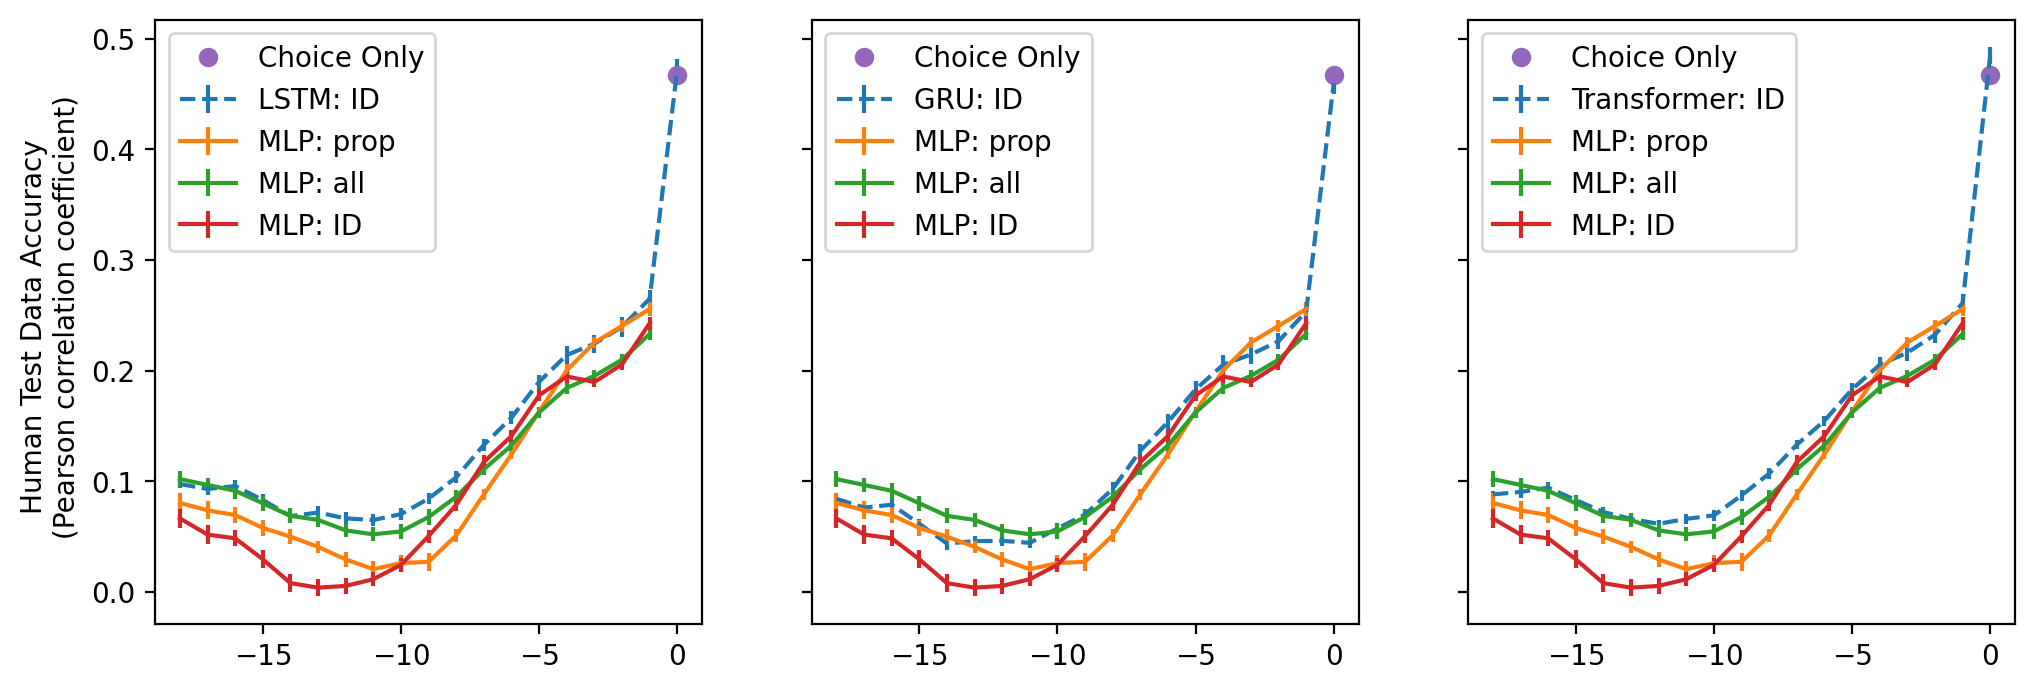

In [38]:
fig,ax = plt.subplots(1,3, figsize = (12,4), dpi = 200, sharex = True, sharey = True)

train_labels = ['Simulated Data Only', 'Human Data Only', 'Simulated and Human Data']

for train_idx, train_name in enumerate(train_names[3:]):

    for model_idx, model_name in enumerate(model_names):
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, which_r_sim = 'r_human_by_n_back', n_runs = 20)

        these_tps = np.arange(-18,1,1)
        # ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), '*', ms=2, label=model_name)
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=sem_r, ls = '--', label = '{}: ID'.format(model_name))
        
        
        these_tps = np.arange(-18,0,1)
        for fu in ['prop', 'all', 'ID']:#['all', 'sum', 'prop', 'ID']:
            mn_r_by_n_back_c, sem_r_c = get_correlation_results_control(fu, c_d_model, 0, .001, 0, 5e5, c_dropout, which_r_sim = 'r_human_by_n_back', n_runs = 20)
            ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back_c[:-1]), yerr = np.flip(sem_r_c[:-1]), label = 'MLP: '+fu)
            
        # get the choice only...
        mn_r_by_n_back, sem_r = get_correlation_results('MLP', train_name, which_r_sim = 'r_human_by_n_back', n_runs = 20, choice_only = True, choice_then_fix = False)
        ax[model_idx].plot(0,mn_r_by_n_back,'o', label = 'Choice Only')
        ax[model_idx].errorbar(0,mn_r_by_n_back,yerr = sem_r)
        print('Choice only pred: ', mn_r_by_n_back)
        
        
for i in range(3):
    ax[i].legend()

    ax[0].set_ylabel('Human Test Data Accuracy \n (Pearson correlation coefficient)');

In [39]:
mn_r_by_n_back, sem_r = get_correlation_results('MLP', train_name, which_r_sim = 'r_human_by_n_back', n_runs = 20, choice_only = True, choice_then_fix = False)
mn_r_by_n_back

0.4667760381978884

In [19]:
mn_r_by_n_back

0.4667760381978884

In [20]:
mn_r_by_n_back

0.4667760381978884

(0.32, 0.75)

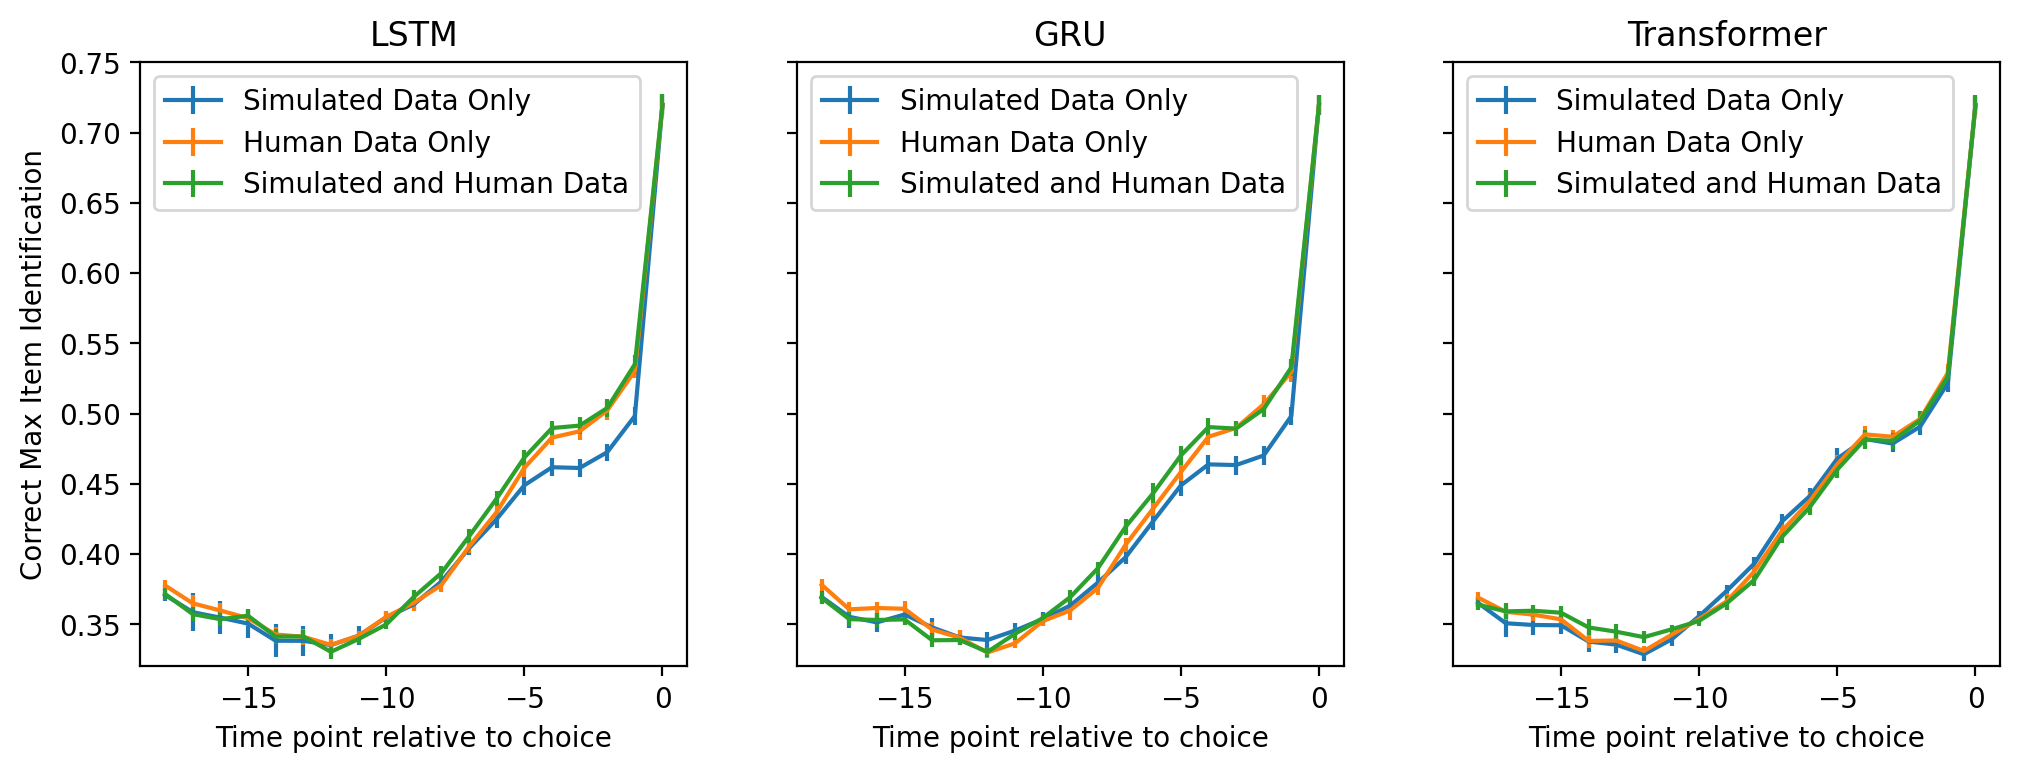

In [13]:
fig,ax = plt.subplots(1,3, figsize = (12,4), dpi = 200, sharex = True, sharey = True)

train_labels = ['Simulated Data Only', 'Human Data Only', 'Simulated and Human Data']

for train_idx, train_name in enumerate(train_names[1:]):

    for model_idx, model_name in enumerate(model_names):
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, which_r_sim = 'pct_correct_max_human_by_n_back', n_runs = 20)

        these_tps = np.arange(-18,1,1)
        #ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), label='fixations + choice')
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=sem_r, label = train_labels[train_idx])

        ax[model_idx].set_title(model_name)
        ax[model_idx].set_xlabel('Time point relative to choice')
        ax[model_idx].legend()

    ax[0].set_ylabel('Correct Max Item Identification');
ax[0].set_ylim(.32, .75)

(0.32, 0.75)

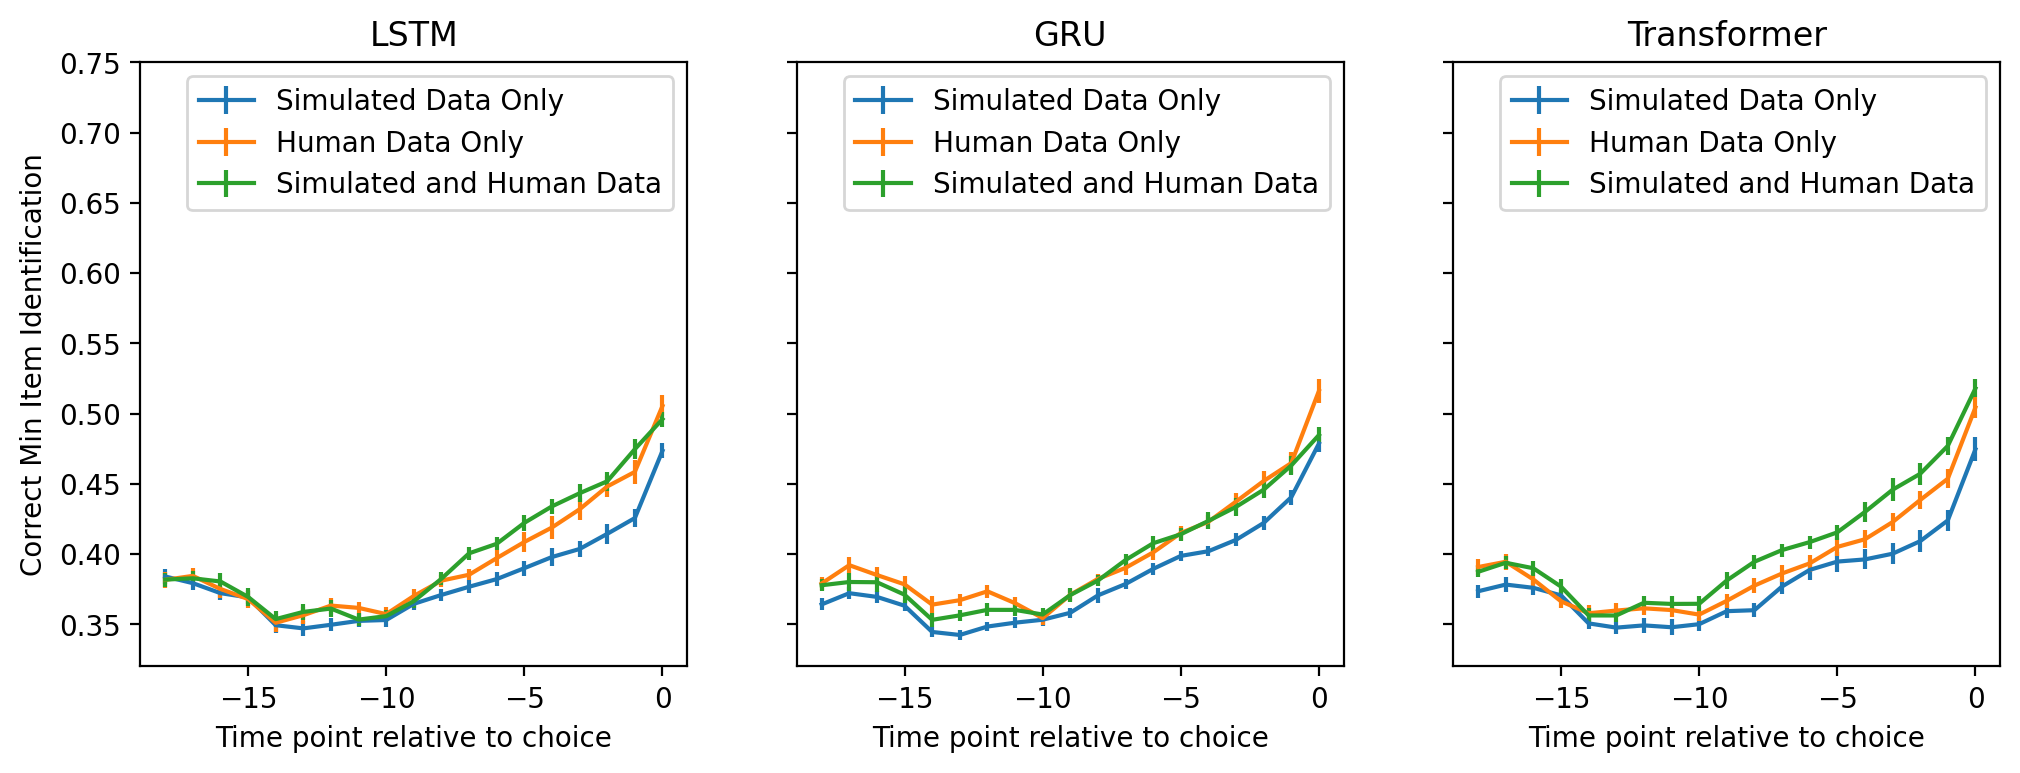

In [14]:
fig,ax = plt.subplots(1,3, figsize = (12,4), dpi = 200, sharex = True, sharey = True)

train_labels = ['Simulated Data Only', 'Human Data Only', 'Simulated and Human Data']

for train_idx, train_name in enumerate(train_names[1:]):

    for model_idx, model_name in enumerate(model_names):
        mn_r_by_n_back, sem_r = get_correlation_results(model_name, train_name, which_r_sim = 'pct_correct_min_human_by_n_back', n_runs = 20)

        these_tps = np.arange(-18,1,1)
        #ax[model_idx].plot(these_tps,np.flip(mn_r_by_n_back), label='fixations + choice')
        ax[model_idx].errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=sem_r, label = train_labels[train_idx])

        ax[model_idx].set_title(model_name)
        ax[model_idx].set_xlabel('Time point relative to choice')
        ax[model_idx].legend()

ax[0].set_ylabel('Human Test Data Accuracy \n (Pearson correlation coefficient)');
ax[0].set_ylabel('Correct Min Item Identification');

ax[0].set_ylim(.32, .75)